In [25]:
import pandas as pd
import numpy as np
import spacy
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Download necessary NLTK data
nltk.download("vader_lexicon")

# Load SpaCy model
nlp = spacy.load("en_core_web_sm")


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\senth\AppData\Roaming\nltk_data...


In [31]:


# Define column names
column_names = [
    "id", "label", "statement", "subject", "speaker", "speaker_job",
    "state", "party", "barely_true", "false", "half_true", "mostly_true",
    "pants_on_fire", "context"
]

# Load the dataset
train_df = pd.read_csv("liar_dataset/train.tsv", sep='\t', names=column_names)
test_df = pd.read_csv("liar_dataset/test.tsv", sep='\t', names=column_names)
valid_df = pd.read_csv("liar_dataset/valid.tsv", sep='\t', names=column_names)

# Display the first few rows
print(train_df.head())

# Check dataset shape (rows, columns)
print("Train Shape:", train_df.shape)
print("Test Shape:", test_df.shape)
print("Validation Shape:", valid_df.shape)

# Check for missing values
print("Missing Values:\n", train_df.isnull().sum())


           id        label                                          statement  \
0   2635.json        false  Says the Annies List political group supports ...   
1  10540.json    half-true  When did the decline of coal start? It started...   
2    324.json  mostly-true  Hillary Clinton agrees with John McCain "by vo...   
3   1123.json        false  Health care reform legislation is likely to ma...   
4   9028.json    half-true  The economic turnaround started at the end of ...   

                              subject         speaker           speaker_job  \
0                            abortion    dwayne-bohac  State representative   
1  energy,history,job-accomplishments  scott-surovell        State delegate   
2                      foreign-policy    barack-obama             President   
3                         health-care    blog-posting                   NaN   
4                        economy,jobs   charlie-crist                   NaN   

      state       party  barely_true  

In [27]:
print(train_df.isnull().sum())  # Check missing values in each column


id                  0
label               0
statement           0
subject             2
speaker             2
speaker_job      2898
state            2210
party               2
barely_true         2
false               2
half_true           2
mostly_true         2
pants_on_fire       2
context           102
dtype: int64


In [32]:
# Drop 'speaker_job' column as it has too many missing values
train_df.drop(columns=['speaker_job'], inplace=True)

# Fill missing categorical values with 'Unknown'
categorical_cols = ['subject', 'speaker', 'state', 'party']
train_df[categorical_cols] = train_df[categorical_cols].fillna("Unknown")

# Fill missing 'context' with an empty string
train_df['context'] = train_df['context'].fillna("")

# Verify no missing values remain
print("Missing Values After Cleaning:\n", train_df.isnull().sum())


Missing Values After Cleaning:
 id               0
label            0
statement        0
subject          0
speaker          0
state            0
party            0
barely_true      2
false            2
half_true        2
mostly_true      2
pants_on_fire    2
context          0
dtype: int64


In [29]:
print(train_df["speaker"].value_counts().head(10))  # Top 10 speakers
print(train_df["party"].value_counts())  # Count of party affiliation


speaker
barack-obama       488
donald-trump       273
hillary-clinton    239
mitt-romney        176
scott-walker       149
john-mccain        148
rick-perry         142
chain-email        142
marco-rubio        117
rick-scott         115
Name: count, dtype: int64
party
republican                      4497
democrat                        3336
none                            1744
organization                     219
independent                      147
newsmaker                         56
libertarian                       40
activist                          39
journalist                        38
columnist                         35
talk-show-host                    26
state-official                    20
labor-leader                      11
tea-party-member                  10
business-leader                    9
green                              3
education-official                 2
liberal-party-canada               1
government-body                    1
Moderate                   

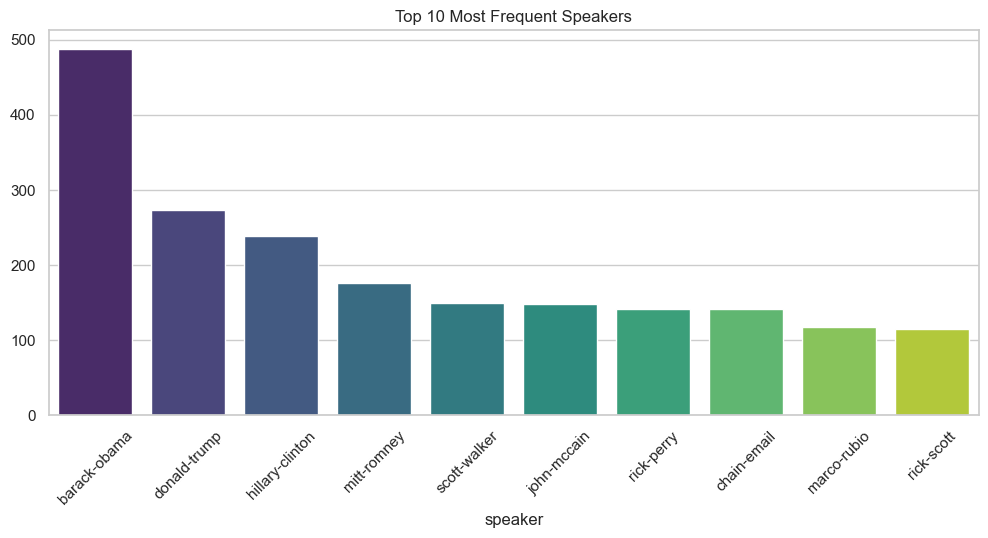

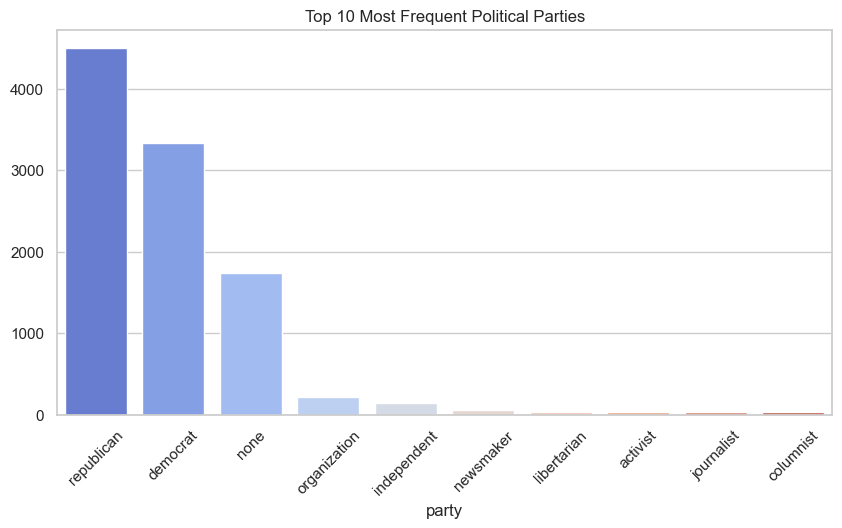

label
half-true      2114
false          1995
mostly-true    1962
true           1676
barely-true    1654
pants-fire      839
Name: count, dtype: int64


In [33]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot Speaker Distribution
plt.figure(figsize=(12,5))
sns.barplot(x=train_df['speaker'].value_counts().head(10).index, 
            y=train_df['speaker'].value_counts().head(10).values, 
            palette='viridis')
plt.xticks(rotation=45)
plt.title("Top 10 Most Frequent Speakers")
plt.show()

# Plot Party Distribution
plt.figure(figsize=(10,5))
sns.barplot(x=train_df['party'].value_counts().head(10).index, 
            y=train_df['party'].value_counts().head(10).values, 
            palette='coolwarm')
plt.xticks(rotation=45)
plt.title("Top 10 Most Frequent Political Parties")
plt.show()

# Check Label Distribution
print(train_df['label'].value_counts())


In [34]:
# Convert multi-class labels into Fake (0) and Real (1)
train_df['binary_label'] = train_df['label'].apply(lambda x: 0 if x in ['false', 'barely-true', 'pants-fire'] else 1)

# Check new label distribution
print(train_df['binary_label'].value_counts())


binary_label
1    5752
0    4488
Name: count, dtype: int64


In [35]:
import spacy

# Load SpaCy model
nlp = spacy.load("en_core_web_sm")

# Define text preprocessing function
def preprocess_text_spacy(text):
    doc = nlp(str(text).lower())  # Convert to lowercase and process text with SpaCy
    words = [token.lemma_ for token in doc if token.is_alpha and not token.is_stop]  # Lemmatization & Stopword removal
    return " ".join(words)

# Apply preprocessing to the 'statement' column
train_df['clean_statement'] = train_df['statement'].apply(preprocess_text_spacy)

# Display first 5 rows after preprocessing
print(train_df[['statement', 'clean_statement']].head())


                                           statement  \
0  Says the Annies List political group supports ...   
1  When did the decline of coal start? It started...   
2  Hillary Clinton agrees with John McCain "by vo...   
3  Health care reform legislation is likely to ma...   
4  The economic turnaround started at the end of ...   

                                     clean_statement  
0  say annie list political group support trimest...  
1  decline coal start start natural gas take star...  
2  hillary clinton agree john mccain vote george ...  
3  health care reform legislation likely mandate ...  
4                 economic turnaround start end term  


In [36]:
from collections import Counter
from itertools import islice

# Function to get top N n-grams
def get_ngrams(texts, n=1, top_n=20):
    ngram_list = []
    
    for text in texts:
        words = text.split()  # Split text into words
        ngrams = zip(*[words[i:] for i in range(n)])  # Create N-Grams
        ngram_list.extend(ngrams)

    # Count frequencies of n-grams
    ngram_freq = Counter(ngram_list).most_common(top_n)
    
    return ngram_freq

# Get top N-grams
top_unigrams = get_ngrams(train_df["clean_statement"], n=1, top_n=20)
top_bigrams = get_ngrams(train_df["clean_statement"], n=2, top_n=20)
top_trigrams = get_ngrams(train_df["clean_statement"], n=3, top_n=20)

# Print results
print("🔹 Top 20 Unigrams:", top_unigrams)
print("\n🔹 Top 20 Bigrams:", top_bigrams)
print("\n🔹 Top 20 Trigrams:", top_trigrams)


🔹 Top 20 Unigrams: [(('say',), 2788), (('year',), 1233), (('percent',), 1190), (('state',), 1103), (('obama',), 755), (('tax',), 706), (('job',), 652), (('president',), 647), (('million',), 639), (('health',), 614), (('vote',), 613), (('people',), 605), (('not',), 538), (('care',), 518), (('pay',), 499), (('new',), 468), (('bill',), 462), (('time',), 443), (('billion',), 429), (('cut',), 424)]

🔹 Top 20 Bigrams: [(('health', 'care'), 413), (('barack', 'obama'), 300), (('united', 'states'), 296), (('hillary', 'clinton'), 189), (('president', 'barack'), 157), (('donald', 'trump'), 133), (('president', 'obama'), 131), (('social', 'security'), 131), (('mitt', 'romney'), 126), (('scott', 'walker'), 124), (('health', 'insurance'), 111), (('raise', 'taxis'), 101), (('say', 'president'), 101), (('tax', 'cut'), 92), (('rhode', 'island'), 91), (('say', 'hillary'), 89), (('federal', 'government'), 81), (('new', 'jersey'), 79), (('illegal', 'immigrant'), 76), (('take', 'office'), 75)]

🔹 Top 20 Tr

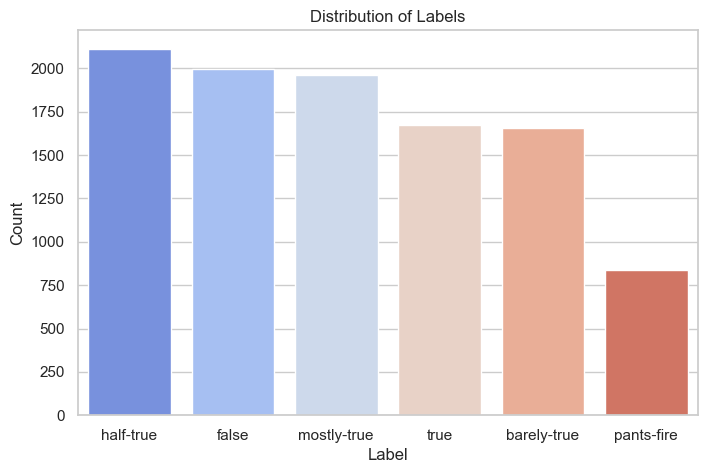

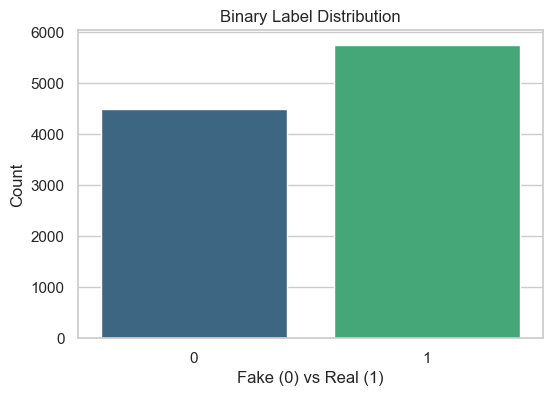

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style
sns.set_style("whitegrid")

# Label distribution
plt.figure(figsize=(8, 5))
sns.countplot(x=train_df["label"], order=train_df["label"].value_counts().index, palette="coolwarm")
plt.xlabel("Label")
plt.ylabel("Count")
plt.title("Distribution of Labels")
plt.show()

# Binary Label distribution (Fake vs. Real)
plt.figure(figsize=(6, 4))
sns.countplot(x=train_df["binary_label"], palette="viridis")
plt.xlabel("Fake (0) vs Real (1)")
plt.ylabel("Count")
plt.title("Binary Label Distribution")
plt.show()


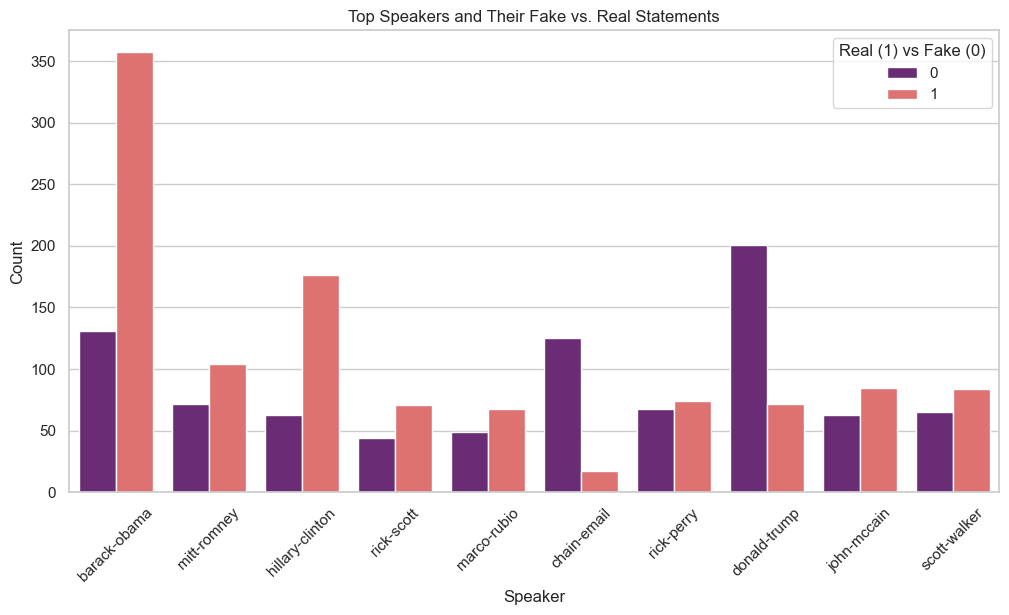

In [38]:
# Top 10 speakers with most statements
top_speakers = train_df["speaker"].value_counts().head(10).index

plt.figure(figsize=(12, 6))
sns.countplot(
    data=train_df[train_df["speaker"].isin(top_speakers)],
    x="speaker",
    hue="binary_label",
    palette="magma"
)
plt.xticks(rotation=45)
plt.xlabel("Speaker")
plt.ylabel("Count")
plt.title("Top Speakers and Their Fake vs. Real Statements")
plt.legend(title="Real (1) vs Fake (0)")
plt.show()


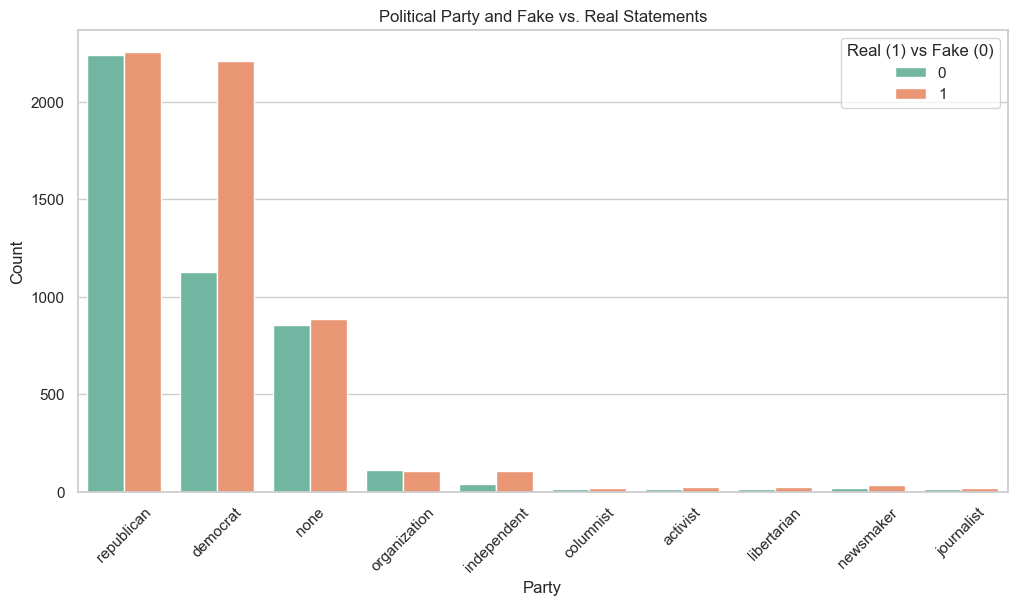

In [39]:
# Top 10 parties with most statements
top_parties = train_df["party"].value_counts().head(10).index

plt.figure(figsize=(12, 6))
sns.countplot(
    data=train_df[train_df["party"].isin(top_parties)],
    x="party",
    hue="binary_label",
    palette="Set2"
)
plt.xticks(rotation=45)
plt.xlabel("Party")
plt.ylabel("Count")
plt.title("Political Party and Fake vs. Real Statements")
plt.legend(title="Real (1) vs Fake (0)")
plt.show()


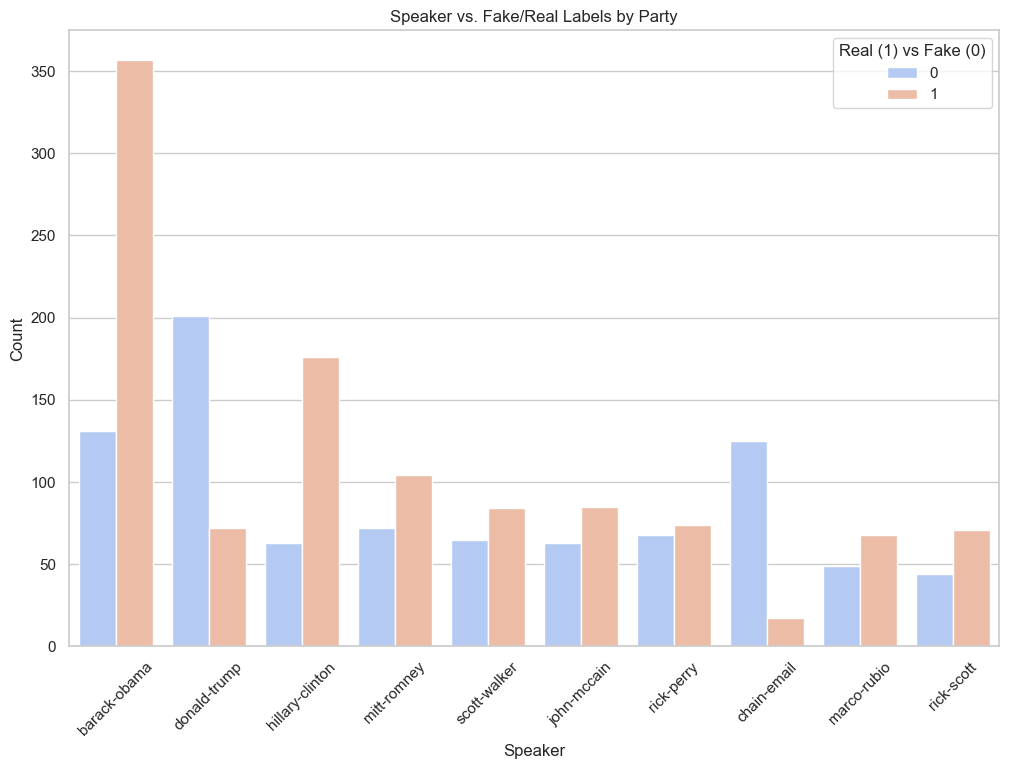

In [40]:
plt.figure(figsize=(12, 8))
sns.countplot(
    data=train_df[train_df["party"].isin(["republican", "democrat", "none"])],  
    x="speaker",
    hue="binary_label",
    palette="coolwarm",
    order=train_df["speaker"].value_counts().head(10).index
)
plt.xticks(rotation=45)
plt.xlabel("Speaker")
plt.ylabel("Count")
plt.title("Speaker vs. Fake/Real Labels by Party")
plt.legend(title="Real (1) vs Fake (0)")
plt.show()


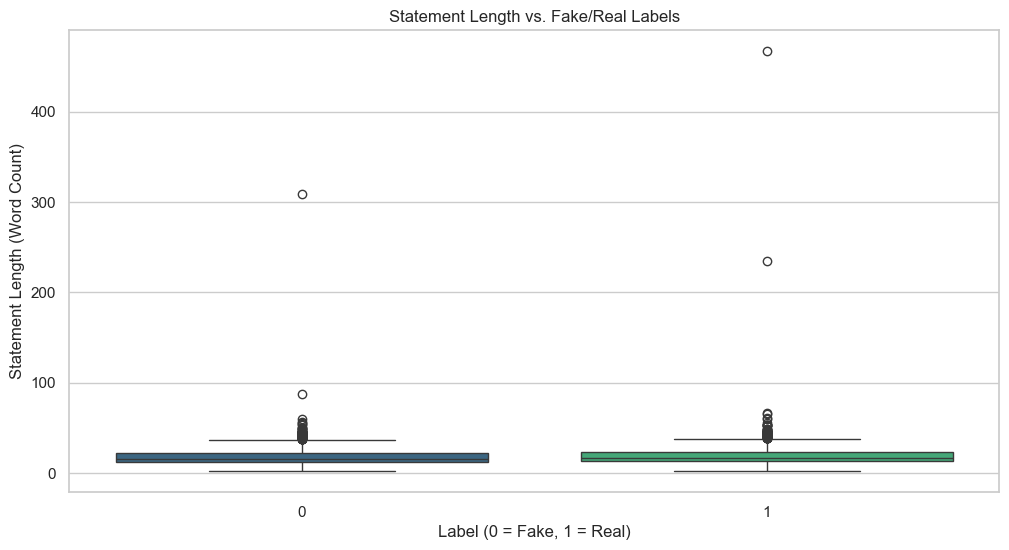

In [41]:
train_df["statement_length"] = train_df["statement"].apply(lambda x: len(x.split()))

plt.figure(figsize=(12, 6))
sns.boxplot(
    data=train_df,
    x="binary_label",
    y="statement_length",
    palette="viridis"
)
plt.xlabel("Label (0 = Fake, 1 = Real)")
plt.ylabel("Statement Length (Word Count)")
plt.title("Statement Length vs. Fake/Real Labels")
plt.show()
